### Training the Model for Quantization Experiments

In this section, we train the original model of a target model type. The trained model will later serve as a baseline for different precision quantization experiments, including FP32, FP16, and INT8. This process helps in evaluating the trade-offs between model accuracy and runtime efficiency across different GPU architectures.

#### Running the Training Script

To train the Resnet18 model, execute the following command:

In [ ]:
!python3 ch train --config resnet18_INT8_quant.toml

To train Resnet50

In [ ]:
!python3 ch train --config resnet50_INT8_quant.toml

To train VGG7

In [ ]:
!python3 ch train --config vgg7_INT8_quant.toml

The training result is saved in `ADLS/mase_output`

## Explore Meta-Learning

For Resnet 18:

In [ ]:
RES18_META_BY_TYPE_TOML = "resnet18_meta.toml"
RES18_CHECKPOINT_PATH = "/workspace/ADLS_Proj/docs/tutorials/proj/model/resnet18/best.ckpt"  # Change the path to your ckpt path

!python ch meta --config {RES18_META_BY_TYPE_TOML} --load {RES18_CHECKPOINT_PATH} --load-type pl

/srcPkgs/miniconda3/lib/python3.11/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
INFO: Seed set to 0
I0320 20:55:53.820242 140701426177088 seed.py:57] Seed set to 0
+-------------------------+--------------------------+----------------------+--------------------------+--------------------------+
| Name                    |         Default          |     Config. File     |     Manual Override      |        Effective         |
+-------------------------+--------------------------+----------------------+--------------------------+--------------------------+
| task                    |      classification      |         cls          |                          |           cls            |
| load_name               |           None           |                      | /workspace/ADLS_Proj/doc | /worksp

For Resnet50:

In [ ]:
RES50_META_BY_TYPE_TOML = "resnet50_meta.toml"
RES50_CHECKPOINT_PATH = "/workspace/ADLS_Proj/docs/tutorials/proj/model/resnet50/best.ckpt"  # Change the path to your ckpt path

!python ch meta --config {RES50_META_BY_TYPE_TOML} --load {RES50_CHECKPOINT_PATH} --load-type pl

/srcPkgs/miniconda3/lib/python3.11/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
INFO: Seed set to 0
I0320 21:58:41.048768 140303353021504 seed.py:57] Seed set to 0
+-------------------------+--------------------------+----------------------+--------------------------+--------------------------+
| Name                    |         Default          |     Config. File     |     Manual Override      |        Effective         |
+-------------------------+--------------------------+----------------------+--------------------------+--------------------------+
| task                    |      classification      |         cls          |                          |           cls            |
| load_name               |           None           |                      | /workspace/ADLS_Proj/doc | /worksp

For VGG7:

In [ ]:
VGG7_META_BY_TYPE_TOML = "vgg7_meta.toml"
VGG7_CHECKPOINT_PATH = "/workspace/ADLS_Proj/docs/tutorials/proj/model/resnet50/best.ckpt"  # Change the path to your ckpt path

!python ch meta --config {VGG7_META_BY_TYPE_TOML} --load {VGG7_CHECKPOINT_PATH} --load-type pl

## Meta-learning Training

Epoch 0: Total Loss=4.3389 | model=1.1332, batch=1.5890, quant=1.6167
Epoch 50: Total Loss=3.1462 | model=0.4202, batch=1.3880, quant=1.3381
Epoch 100: Total Loss=2.9825 | model=0.3538, batch=1.3595, quant=1.2692
Epoch 150: Total Loss=2.7976 | model=0.3208, batch=1.3125, quant=1.1642
Epoch 200: Total Loss=2.5958 | model=0.2929, batch=1.2558, quant=1.0472
Epoch 250: Total Loss=2.4154 | model=0.2746, batch=1.2017, quant=0.9392
Epoch 300: Total Loss=2.2863 | model=0.2628, batch=1.1608, quant=0.8627
Epoch 350: Total Loss=2.1910 | model=0.2563, batch=1.1280, quant=0.8067
Epoch 400: Total Loss=2.1143 | model=0.2519, batch=1.1003, quant=0.7622
Epoch 450: Total Loss=2.0488 | model=0.2492, batch=1.0753, quant=0.7242
Training completed.

Sample Predictions:
Input: [0.16960922 0.73537171 0.11308723]
    Predicted: resnet18, batch=128, quant=tensorrt_fp32
    True: resnet18, batch=8, quant=tensorrt_fp32

Input: [0.13152176 0.94151827 0.09259875]
    Predicted: vgg7_cifar, batch=64, quant=tensorrt_

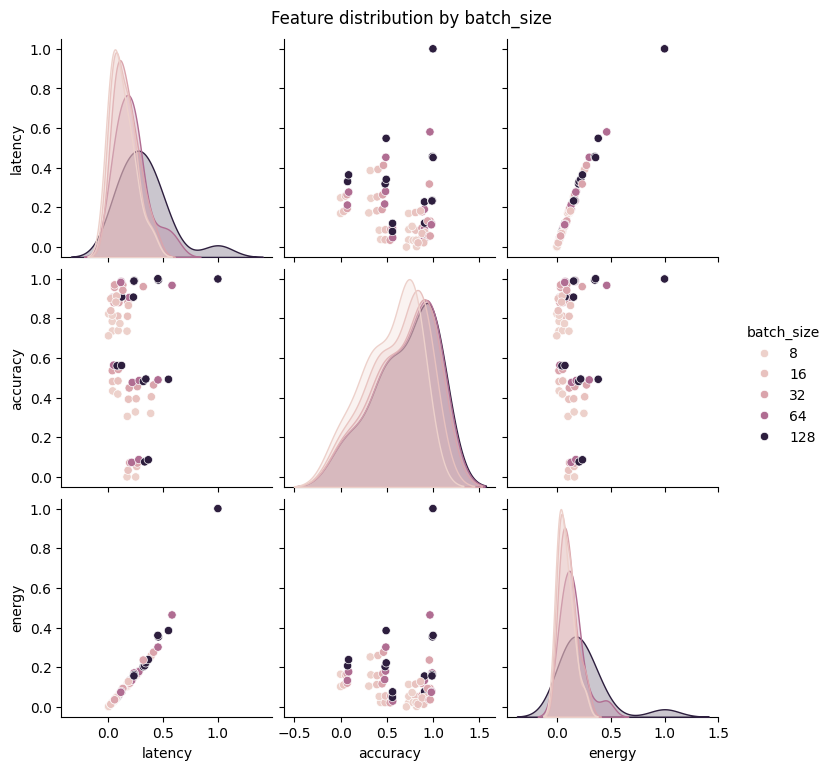

In [ ]:
# Import necessary libraries
from pathlib import Path
import random
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import os
import seaborn as sns

# Set seeds to reproduce
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load csv results
csv_files = glob.glob("results/A100/*.csv")
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Normalize numerical features: latency, accuracy, energy
scaler = MinMaxScaler()
df[["latency", "accuracy", "energy"]] = scaler.fit_transform(df[["latency", "accuracy", "energy"]])

# Visualize data distribution
plot_path = Path("feature_distribution_by_batch_size.png")
sns_plot = sns.pairplot(df, hue="batch_size", vars=["latency", "accuracy", "energy"])
plt.suptitle("Feature distribution by batch_size", y=1.02)
plt.savefig(plot_path, dpi=150, bbox_inches="tight")

# Encode categorical labels to integer indices
model_le = LabelEncoder()
batch_le = LabelEncoder()
quant_le = LabelEncoder()


df["model_label"] = model_le.fit_transform(df["model_name"])
df["batch_label"] = batch_le.fit_transform(df["batch_size"])
df["quant_label"] = quant_le.fit_transform(df["quant_method"])


# Extract input features and target labels
X = df[["latency", "accuracy", "energy"]].values
y_model = df["model_label"].values
y_batch = df["batch_label"].values
y_quant = df["quant_label"].values

# Split the dataset into training and testing sets
X_train, X_test, y_model_train, y_model_test, y_batch_train, y_batch_test, y_quant_train, y_quant_test = train_test_split(
    X, y_model, y_batch, y_quant, test_size=0.2, random_state=42
)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_model_tensor = torch.LongTensor(y_model_train)
y_batch_tensor = torch.LongTensor(y_batch_train)
y_quant_tensor = torch.LongTensor(y_quant_train)

X_test_tensor = torch.FloatTensor(X_test)

# Define the multi-head neural network for multi-task classification
class MultiHeadPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, model_classes, batch_classes, quant_classes):
        super(MultiHeadPolicyNetwork, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.model_head = nn.Linear(hidden_dim, model_classes)
        self.batch_head = nn.Linear(hidden_dim, batch_classes)
        self.quant_head = nn.Linear(hidden_dim, quant_classes)

    def forward(self, x):
        shared = self.shared(x)
        return self.model_head(shared), self.batch_head(shared), self.quant_head(shared)

# Set model parameters
input_dim = 3
hidden_dim = 64
model_classes = len(model_le.classes_)
batch_classes = len(batch_le.classes_)
quant_classes = len(quant_le.classes_)

# Instantiate the model, loss function, and optimizer
model = MultiHeadPolicyNetwork(input_dim, hidden_dim, model_classes, batch_classes, quant_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    pred_model, pred_batch, pred_quant = model(X_train_tensor)

    loss_model = criterion(pred_model, y_model_tensor)
    loss_batch = criterion(pred_batch, y_batch_tensor)
    loss_quant = criterion(pred_quant, y_quant_tensor)

    total_loss = loss_model + loss_batch + loss_quant
    total_loss.backward()
    optimizer.step()

    # Log progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Total Loss={total_loss.item():.4f} | model={loss_model.item():.4f}, batch={loss_batch.item():.4f}, quant={loss_quant.item():.4f}")

print("Training completed.")

# Inference and decoding predictions
model.eval()
with torch.no_grad():
    pred_model, pred_batch, pred_quant = model(X_test_tensor)

    pred_model_labels = torch.argmax(pred_model, dim=1).numpy()
    pred_batch_labels = torch.argmax(pred_batch, dim=1).numpy()
    pred_quant_labels = torch.argmax(pred_quant, dim=1).numpy()

    # Decode predicted labels to original category names
    model_pred_names = model_le.inverse_transform(pred_model_labels)
    batch_pred_sizes = batch_le.inverse_transform(pred_batch_labels)
    quant_pred_methods = quant_le.inverse_transform(pred_quant_labels)

    # Display a few prediction examples
    print("\nSample Predictions:")
    for i in range(5):
        print(f"Input: {X_test[i]}")
        print(f"    Predicted: {model_pred_names[i]}, batch={batch_pred_sizes[i]}, quant={quant_pred_methods[i]}")
        print(f"    True: {model_le.inverse_transform([y_model_test[i]])[0]}, batch={batch_le.inverse_transform([y_batch_test[i]])[0]}, quant={quant_le.inverse_transform([y_quant_test[i]])[0]}")
        print("")

# Configuration recommendation function
def recommend_best_config(*, target_latency, target_accuracy, target_energy):
    """
    Recommend the most suitable model_name, batch_size, and quant_method
    based on target latency, accuracy, and energy constraints.
    """
    # Prepare input DataFrame for normalization
    input_df = pd.DataFrame([{
        "latency": target_latency,
        "accuracy": target_accuracy,
        "energy": target_energy
    }])

    # Normalize using previously fitted scaler
    scaled_input = scaler.transform(input_df)

    # Convert to tensor for model inference
    input_tensor = torch.FloatTensor(scaled_input)

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        pred_model, pred_batch, pred_quant = model(input_tensor)

    # Decode prediction to original labels
    model_idx = torch.argmax(pred_model, dim=1).item()
    batch_idx = torch.argmax(pred_batch, dim=1).item()
    quant_idx = torch.argmax(pred_quant, dim=1).item()

    best_model = model_le.inverse_transform([model_idx])[0]
    best_batch_size = batch_le.inverse_transform([batch_idx])[0]
    best_quant_method = quant_le.inverse_transform([quant_idx])[0]

    return {
        "Model": best_model,
        "Batch Size": best_batch_size,
        "Quant Method": best_quant_method
    }

# Example usage
recommendation = recommend_best_config(
    target_latency=0.5,
    target_accuracy=0.7,
    target_energy=0.002
)

print("Recommended Result:", recommendation)

def decode_prediction(pred_tuple):
    """Decode prediction tensors from the model's 3-head outputs."""
    pred_model_tensor, pred_batch_tensor, pred_quant_tensor = pred_tuple

    model_preds = pred_model_tensor.argmax(dim=1).cpu().numpy()
    batch_preds = pred_batch_tensor.argmax(dim=1).cpu().numpy()
    quant_preds = pred_quant_tensor.argmax(dim=1).cpu().numpy()

    return model_preds, batch_preds, quant_preds


def evaluate_model(model, X_test_tensor, y_model_test, y_batch_test, y_quant_test):
    """
    Evaluate the model and report accuracy for each prediction head,
    as well as full-match accuracy across all three outputs.
    """
    model.eval()
    with torch.no_grad():
        pred_tuple = model(X_test_tensor)

    pred_model, pred_batch, pred_quant = decode_prediction(pred_tuple)

    acc_model = np.mean(pred_model == y_model_test)
    acc_batch = np.mean(pred_batch == y_batch_test)
    acc_quant = np.mean(pred_quant == y_quant_test)

    acc_full = np.mean(
        (pred_model == y_model_test) &
        (pred_batch == y_batch_test) &
        (pred_quant == y_quant_test)
    )

    print(f"Model Accuracy:        {acc_model:.4f}")
    print(f"Batch Size Accuracy:   {acc_batch:.4f}")
    print(f"Quant Method Accuracy: {acc_quant:.4f}")
    print(f"Full Match Accuracy:   {acc_full:.4f}")

    return {
        "model_acc": acc_model,
        "batch_acc": acc_batch,
        "quant_acc": acc_quant,
        "full_match_acc": acc_full
    }

# Call the evaluation function
metrics = evaluate_model(model, X_test_tensor, y_model_test, y_batch_test, y_quant_test)